In [1]:
import torch
import yolov5.utils
display = yolov5.utils.notebook_init()  # checks
import matplotlib.pyplot as plt
import cv2
import rospy

%matplotlib inline
# important to start the node
rospy.init_node('yolo_test_node')


YOLOv5 🚀 2024-1-24 Python-3.8.10 torch-2.1.2+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 7931MiB)


Setup complete ✅ (16 CPUs, 14.8 GB RAM, 193.4/245.0 GB disk)


In [2]:
import ros_numpy
import numpy as np
from sensor_msgs.msg import Image , LaserScan , PointCloud2
class RGBD():
    def __init__(self):
        
        self._cloud_sub = rospy.Subscriber(
            "/camera/depth_registered/points",
            PointCloud2, self._cloud_cb)
        self._points_data = None
        self._image_data = None
        

    def _cloud_cb(self, msg):
        self._points_data = ros_numpy.numpify(msg)
        self._image_data = self._points_data['rgb'].view((np.uint8, 4))[..., [2, 1, 0]]
        

    def get_image(self):
        return self._image_data

    def get_points(self):
        return self._points_data

In [3]:
rgbd = RGBD()


<class 'numpy.ndarray'>


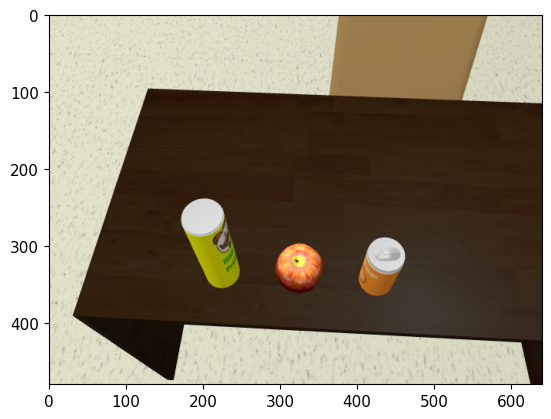

In [4]:
test_img = rgbd.get_image()
print(type(test_img))
plt.imshow(test_img)

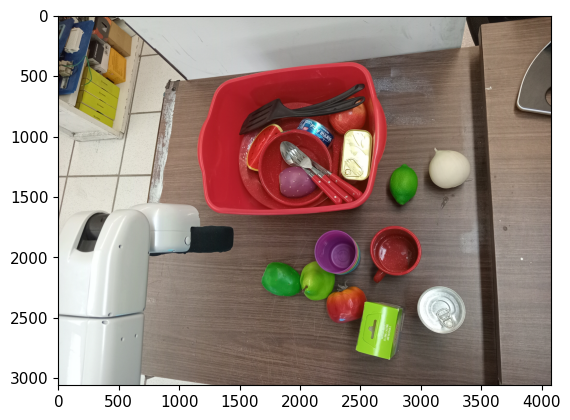

In [5]:
import rospkg
import os
import matplotlib.image as mpimg

rpg = rospkg.RosPack()
package_path = rpg.get_path('vision_modules')
img_path = os.path.join(package_path, "scripts")

img = mpimg.imread(img_path + '/20240223_171508.jpg')
plt.imshow(img)

In [6]:
from yolov5.models.experimental import attempt_load
from yolov5.utils.general import *
from yolov5.utils.torch_utils import select_device

from cv_bridge import CvBridge
from object_classification.srv import Classify,ClassifyResponse, ClassifyRequest
import torch

device = select_device('')

file_path = rpg.get_path('object_classification')
ycb_yolo_path=file_path+'/src/weights/ycb.pt'
print(ycb_yolo_path)
model=attempt_load(ycb_yolo_path,device)


YOLOv5 🚀 2024-1-24 Python-3.8.10 torch-2.1.2+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 7931MiB)



/home/devan/GIT/Juskeshino/catkin_ws/src/vision/object_classification/src/weights/ycb.pt


Fusing layers... 
Model summary: 369 layers, 21138024 parameters, 0 gradients, 49.1 GFLOPs


(480, 640, 3)
<class 'numpy.ndarray'>
[tensor([[4.01854e+02, 2.89904e+02, 4.61784e+02, 3.64221e+02, 9.25071e-01, 2.10000e+01],
        [2.94410e+02, 2.97939e+02, 3.54019e+02, 3.60066e+02, 8.88301e-01, 1.60000e+01],
        [1.71799e+02, 2.39316e+02, 2.47872e+02, 3.54102e+02, 6.61945e-01, 1.00000e+00],
        [2.94384e+02, 2.97894e+02, 3.52869e+02, 3.60888e+02, 4.30941e-01, 1.20000e+01]], device='cuda:0')]
torch.Size([4, 6])


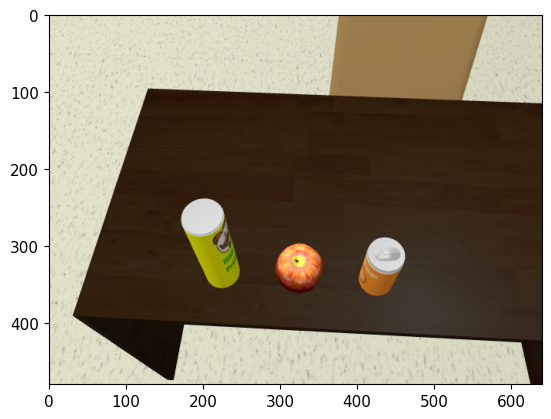

In [8]:
sampling_img = test_img
print(sampling_img.shape)
sample = torch.from_numpy(sampling_img).to(device)
sample = sample / 255.0
sample = sample.unsqueeze(0)
sample = torch.moveaxis(sample, 3, 1)
pred = model(sample, augment=False)[0]

plt.imshow(sampling_img)
print(type(sampling_img))


detections = non_max_suppression(pred)  # IOU 
print(detections)
print(detections[0].shape)

1 (401, 289) (461, 364) 0.9250710010528564 021_bleach_cleanser
2 (294, 297) (354, 360) 0.8883005380630493 017_orange
3 (171, 239) (247, 354) 0.6619451642036438 002_master_chef_can
4 (294, 297) (352, 360) 0.4309408664703369 013_apple


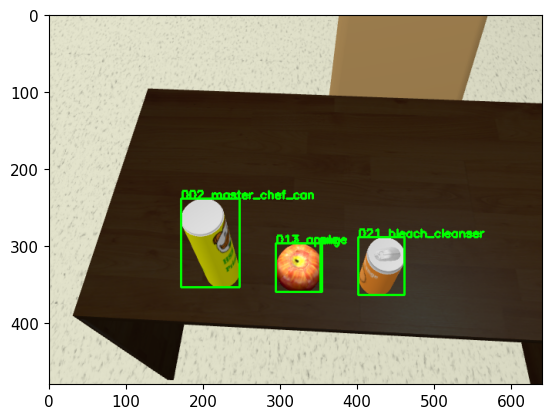

In [34]:
debug_img = sampling_img.copy()

num_preds = 0
points = []
confidence_threshold = 0.4

for detect in detections:
    for *xyxy, conf, cls in (detect):# Model Result is bounding box  confidence  and class
        if conf.cpu().tolist() > confidence_threshold:
            num_preds+=1
            pt_min = (int(xyxy[0].cpu().tolist()), int(xyxy[1].cpu().tolist()))
            pt_max = (int(xyxy[2].cpu().tolist()), int(xyxy[3].cpu().tolist()))

            points.append((pt_min, pt_max))

            debug_img = cv2.rectangle(debug_img ,pt_min,pt_max,  (0, 255, 0), 2)
            debug_img = cv2.putText(debug_img, model.names[int(cls.cpu().tolist())],
                        pt_min, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            print(num_preds, pt_min, pt_max, conf.cpu().tolist(), model.names[int(cls.cpu().tolist())] )
    
plt.imshow(debug_img)